In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.3 s, sys: 352 ms, total: 11.7 s
Wall time: 9.32 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
# region_id = 'freiburg'
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'
# cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
# val_path = '../data/fbg_cluster_validation.pq'

In [4]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [5]:
# spatial_lag = 3
# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}_sw.parquet')

# lag = lag[[c for c in lag.columns if '_median' in c]]

# # lag = lag.drop(lag.columns[(lag.columns.str.startswith('l')) | (lag.columns.str.startswith('m'))], axis=1)

# X_train = X_train.join(lag, how='inner')

# # X_train = lag

In [6]:
chars_to_drop = [
    [],
    ['stcSAl', 'stcOri'],
    [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
          
]

In [7]:
centroids = shapely.get_coordinates(tessellation.representative_point())

In [8]:
linkage = 'ward'
metric = 'euclidean'

tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
    .loc[tess_groups.index]
    .values
)

In [9]:
clips = [None, (-5,5), (-10, 10)]

In [ ]:
%%capture cap

results = []

for spatial_lag in [1,2,3,4,5]:
    
    for kernel in ['gaussian', 'inverse', 'weights']:

        lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)

        for lag_type in ['_median', '_iqr', '_']:
            
            clustering_data = X_train.join(lag[[c for c in lag.columns if lag_type in c]], how='inner')
            
            for min_cluster_size in [50, 75, 100, 150, 250]:
                
                for to_drop in chars_to_drop:

                    for clip in clips:
                    
                        try:
                            region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)
                            ars = adjusted_rand_score(tess_groups.values, region_cluster_labels.iloc[tess_groups_ilocs].values)
                            results.append([spatial_lag, kernel, lag_type, clip, min_cluster_size, to_drop, ars])
                        except Exception as e:
                            print(f"spatial lag: {spatial_lag}, kernel: {kernel}, lag_type: {lag_type}, min_cluster_size: {min_cluster_size}, to_drop: {to_drop}")
                            print(e)

In [ ]:
results = pd.DataFrame(results, columns= ['spatial_lag', 'kernel', 'lag_type', 'clip', 'min_cluster_size', 'dropped_cols', 'ars'])
results

In [ ]:
results.to_parquet(f'../data/cluster_log_{region_id}.pq')

In [62]:
# results = pd.read_parquet(f'cluster_log_{region_id}.pq')

----

In [191]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [192]:
min_cluster_size = 100
spatial_lag = 3
kernel='gaussian'
to_drop = ['stcSAl', 'stcOri']
lag_type = '_median'

clip = (-10,10)
linkage='ward'
metric='euclidean'

In [193]:
%%time
lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

CPU times: user 21.5 s, sys: 1.77 s, total: 23.3 s
Wall time: 3.1 s


In [194]:
clustering_data.shape

(36183, 126)

In [195]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 2.86 s, sys: 153 ms, total: 3.02 s
Wall time: 2.92 s


In [196]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [197]:
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels
labels.value_counts()

component labels
3     34505
4       771
21      614
23       79
9        18
7        17
24       16
6         8
22        7
19        5
8         4
25        3
26        2
5         2
28        2
18        1
27        1
20        1
0         1
17        1
16        1
15        1
1         1
13        1
12        1
11        1
10        1
2         1
14        1
Name: count, dtype: int64

In [198]:
label = 3
labels.groupby(labels).get_group(label).shape

(34505,)

In [199]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [200]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [201]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(34505, 4)

In [202]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [203]:
plotting['label'].nunique()

176

In [207]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [205]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 556 ms, sys: 44.9 ms, total: 601 ms
Wall time: 600 ms


In [206]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [74]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [289]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 2.83 s, sys: 379 μs, total: 2.83 s
Wall time: 2.83 s


In [291]:
# clrs_geometry.explore()

In [292]:
clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}.pq')

----

In [208]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [209]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [210]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [211]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [212]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 1.33 s, sys: 324 μs, total: 1.33 s
Wall time: 1.33 s


In [213]:
component_data

sdbAre                                  sdbPer             \
       percentile_10      median percentile_90 percentile_10     median   
0_1.0     158.469588  158.469588    158.469588     51.195015  51.195015   
10_1.0     24.995869   24.995869     24.995869     20.325831  20.325831   
11_1.0      6.378458    6.378458      6.378458     10.146418  10.146418   
12_1.0    117.428260  117.428260    117.428260     44.472631  44.472631   
13_1.0    134.018525  134.018525    134.018525     56.066456  56.066456   
...              ...         ...           ...           ...        ...   
5_1.0      71.601454  127.778758    183.956061     36.044147  51.116402   
6_1.0      16.593783   22.347574    104.627653     17.377131  19.745407   
7_1.0      18.271826  166.434128    565.836413     17.577434  52.009857   
8_1.0      55.468548   66.930641    155.223430     31.041228  40.410358   
9_1.0      14.158693   92.076144   2532.373037     15.417828  40.555035   

                            sdbCoA                             ssbCCo  ...  \
       percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_1.0      51.195015           0.0    0.0           0.0      0.595764  ...   
10_1.0     20.325831           0.0    0.0           0.0      0.595020  ...   
11_1.0     10.146418           0.0    0.0           0.0      0.624573  ...   
12_1.0     44.472631           0.0    0.0           0.0      0.643355  ...   
13_1.0     56.066456           0.0    0.0           0.0      0.392704  ...   
...              ...           ...    ...           ...           ...  ...   
5_1.0      66.188657           0.0    0.0           0.0      0.429574  ...   
6_1.0      39.857137           0.0    0.0           0.0      0.437883  ...   
7_1.0     125.681820           0.0    0.0           0.0      0.291255  ...   
8_1.0      52.342059           0.0    0.0           0.0      0.293687  ...   
9_1.0     344.754346           0.0    0.0           0.0      0.237455  ...   

              ltkWNB        likWBB                                 sdsAre  \
       percentile_90 percentile_10    median percentile_90  percentile_10   
0_1.0       0.003107      0.006032  0.006032      0.006032  131150.244631   
10_1.0      0.001542      0.000748  0.000748      0.000748  110517.333155   
11_1.0      0.001567      0.000197  0.000197      0.000197   72872.139955   
12_1.0      0.005650      0.006385  0.006385      0.006385   35802.256088   
13_1.0      0.003085      0.004432  0.004432      0.004432  110936.743070   
...              ...           ...       ...           ...            ...   
5_1.0       0.009315      0.007682  0.009550      0.011418  123988.920003   
6_1.0       0.001357      0.009704  0.009704      0.009704   27294.158889   
7_1.0       0.001766      0.028962  0.041850      0.041850  216162.254352   
8_1.0       0.001209      0.007972  0.007972      0.007972  216162.254352   
9_1.0       0.001464      0.165478  0.165478      0.165478   96713.265454   

                                            likWCe                          
               median  percentile_90 percentile_10    median percentile_90  
0_1.0   131150.244631  131150.244631      0.000038  0.000038      0.000038  
10_1.0  110517.333155  110517.333155      0.000030  0.000030      0.000030  
11_1.0   72872.139955   72872.139955      0.000031  0.000031      0.000031  
12_1.0   35802.256088   35802.256088      0.000054  0.000054      0.000054  
13_1.0  110936.743070  110936.743070      0.000033  0.000033      0.000033  
...               ...            ...           ...       ...           ...  
5_1.0   123988.920003  123988.920003      0.000067  0.000093      0.000119  
6_1.0    29342.595346   29342.595346      0.000187  0.000187      0.000187  
7_1.0   216162.254352  216162.254352      0.000114  0.000144      0.000144  
8_1.0   216162.254352  216162.254352      0.000084  0.000084      0.000084  
9_1.0    96713.265454   96713.265454      0.000191  0.000191      0.000191  

[212 rows x 189 col

In [214]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [215]:
umap_metric ='euclidean'

In [216]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=15, n_components=20, min_dist=0, metric=umap_metric, verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

UMAP(min_dist=0, n_components=20, verbose=True)
Tue Aug 27 17:08:13 2024 Construct fuzzy simplicial set
Tue Aug 27 17:08:13 2024 Finding Nearest Neighbors
Tue Aug 27 17:08:13 2024 Finished Nearest Neighbor Search
Tue Aug 27 17:08:13 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 27 17:08:14 2024 Finished embedding


In [275]:
final_linkage = 'ward'

In [276]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

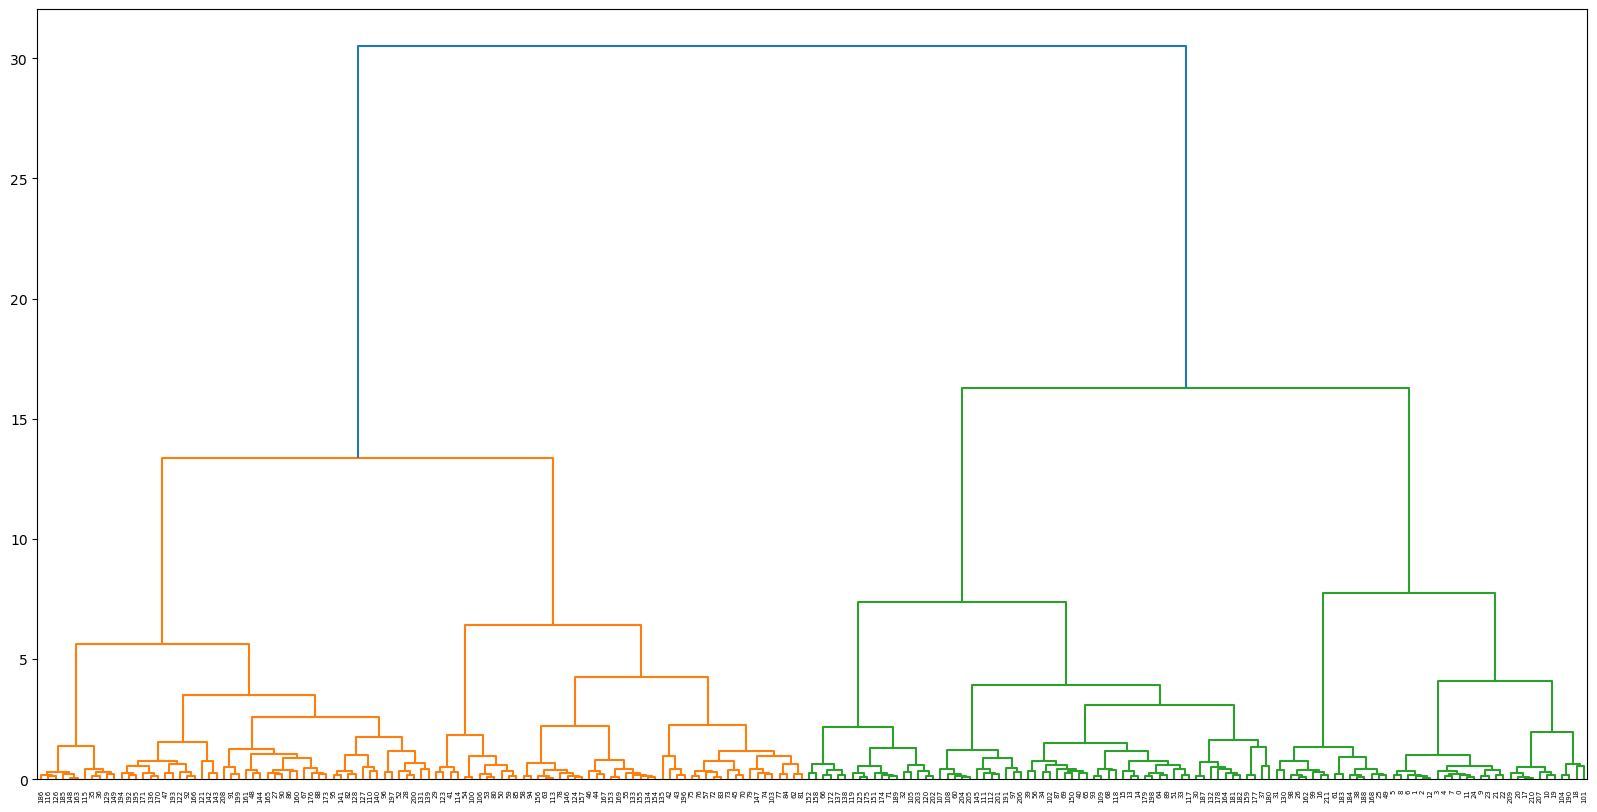

In [277]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [279]:
cutoff = 2

In [280]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')

In [281]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=25, max_iter=5000, n_init=300).fit(embedding).labels_

In [282]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values

In [283]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [284]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [285]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=int32),
 array([2292, 2923, 2609, 2719, 2290, 2160, 1765,  610, 3141, 1010, 1920,
        1755, 3960, 3779, 2717,   18,  399]))

In [227]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 598 ms, sys: 47.9 ms, total: 646 ms
Wall time: 645 ms


In [228]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [286]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [293]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

In [296]:
# clrs_geometry.explore(column=clrs_geometry.index.values.astype(str), categorical=True)

In [297]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{cutoff}.pq')

In [156]:
# gpd.read_parquet(f'../data/clusters__umap_{region_id}_{min_cluster_size}.pq').explore()

In [51]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [52]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(166757, 126)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')